In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tqdm import trange

In [ ]:

def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistividad $(\Omega$m$)$', zlabel='Profundidad (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

In [ ]:
@tf.function
def forward(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant([4, 8, 15, 23], dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
synres = tf.constant([35, 150, 350, 90, 20], dtype = tf.float64)
synthk = tf.constant([4, 8, 15, 23], dtype = tf.float64)

In [ ]:
synthetic_data = forward(synres)

noise_level = 0.03

raw_noise = tf.random.normal(
    shape=tf.shape(synthetic_data),
    mean=0.0,
    stddev=1.0,
    dtype=tf.float64
)

p = 1.05
scaled_noise = raw_noise * (noise_level * tf.pow(tf.abs(synthetic_data), p))

synthetic_data = synthetic_data + scaled_noise

synthetic_data_log = tf.cast(
    tf.math.log(synthetic_data) / tf.math.log(tf.constant(10.0, dtype=tf.float64)),
    dtype=tf.float64
)

In [ ]:
print(synthetic_data)

tf.Tensor(
[ 34.78770014  36.65801125  38.19420213  40.07025392  40.78571088
  44.11809774  47.6657708   50.18661879  51.81112329  60.92716299
  66.73953732  73.29004422  77.4145133   79.57781686  97.41704227
 101.28068782 107.83432928 121.56998776 128.61217258 139.78354561
 132.17652891 138.54111992 147.76785806 138.77965016 119.79001114
 121.95961723 109.09045205  99.58721903  77.93224078  67.24571037], shape=(30,), dtype=float64)


In [ ]:
print(np.sum(np.logspace(0.0, 0.9, 15)))

51.463933821499204


In [ ]:
@tf.function
def forwarde(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant(np.logspace(0.0, 0.9, 15), dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
#RED PAUL GOYES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

def build_model(input_dim, output_dim, nc, ly):
    #regout = OuterLayer()
    # Define the input layer



    input_layer = Input(shape=(input_dim,))
    #previous_layer = input_layer
    previous_layer = Dense(nc, activation='relu')(input_layer)
    # Initialize a list to hold the hidden layers tf.keras.layers.LeakyReLU()
    hidden_layers = []

    # Create the hidden layers
    for _ in range(ly):
        hidden_layer = Dense(nc, activation='relu',kernel_regularizer='l1')(previous_layer)
        hidden_layers.append(hidden_layer)
        previous_layer = keras.layers.add([previous_layer, hidden_layer])  # Sum with the previous layer

    # Add the output layer
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage:
input_dim = 30  # Adjust based on your input size
output_dim = 16  # Adjust based on your output size
nc = 128*4  # Number of channels per hidden layer
ly = 1  # Number of hidden layers

model = build_model(input_dim, output_dim, nc, ly)

In [ ]:
#num_layers = 25  # Número de espesores
X_train = tf.reshape(synthetic_data_log, (1, len(synthetic_data_log)))
print(X_train)

tf.Tensor(
[[1.54142572 1.5641689  1.58199744 1.60282209 1.61050804 1.64461678
  1.67820662 1.70058794 1.71442301 1.78481096 1.82438319 1.86504498
  1.88882239 1.90079202 1.98863494 2.00552664 2.03275704 2.08482637
  2.10928207 2.14545605 2.12115434 2.14157869 2.16957998 2.14232579
  2.07842061 2.08621605 2.03778674 1.9982036  1.89171716 1.82766459]], shape=(1, 30), dtype=float64)


In [ ]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4)
@tf.function
def train(model, d_obs):
    with tf.GradientTape() as tape:
        model_pred = tf.squeeze(model(d_obs, training=True))

        scaled_model_pred = 10 ** (3 * model_pred)
        d_pred = forwarde(scaled_model_pred)

        log_d_pred = tf.math.log(d_pred) / tf.math.log(tf.constant(10.0, dtype=tf.float64))

        # Calcular la segunda parte de la pérdida (diff / logspace_tensor)
        diff = tf.math.subtract(model_pred[1:], model_pred[:-1])
        diff = tf.cast(diff, dtype=tf.float64)
        logspace_tensor = tf.constant(np.logspace(0.0, 0.9, 15), dtype=tf.float64)

        loss_diff = tf.nn.l2_loss(diff / logspace_tensor)

        # Pérdida total
        loss = (0.5) * tf.norm(d_obs - log_d_pred, ord=2) + loss_diff

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss

In [ ]:
# Entrenamiento
loss_i = []
niter = trange(300)
model = build_model(input_dim, output_dim, nc, ly)
for i in niter:
    loss = train(model, X_train)
    loss_i.append(loss.numpy())
    niter.set_postfix(LOSS=loss.numpy())

100%|██████████| 300/300 [00:18<00:00, 16.06it/s, LOSS=0.0441]


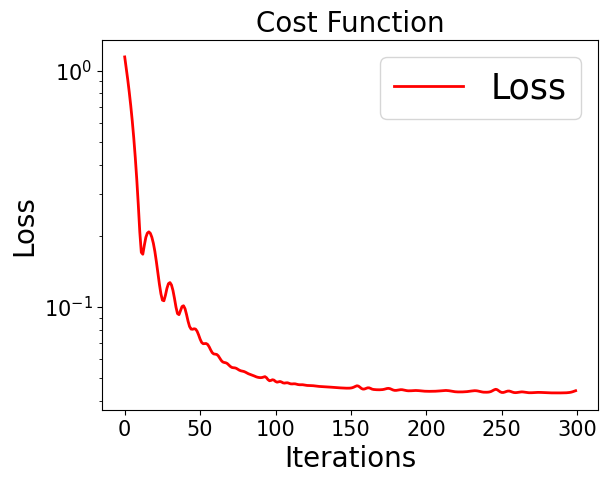

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico
plt.plot(loss_i, label='Loss', color='red', linewidth=2)  # Grosor de la línea aumentado
plt.title('Cost Function', fontsize=20)  # Título más corto con fuente más grande
plt.xlabel('Iterations', fontsize=20)  # Tamaño de fuente mayor para las etiquetas
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=25)  # Aumentar tamaño de fuente de la leyenda
plt.grid(False)

# Aumentar tamaño de los ticks en los ejes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')

# Guardar el gráfico como PNG de alta calidad
plt.savefig('loss_plot.svg', format='svg', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Descargar el archivo generado (descomentar si estás usando Colab)
#files.download('loss_plot.svg')


In [ ]:
ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)

In [ ]:
print(ab2)

tf.Tensor(
[  2.51188643   2.89780372   3.34301197   3.85662042   4.44913785
   5.13268755   5.92125539   6.83097599   7.88046282   9.09118906
  10.48792698  12.09925474  13.95814116  16.10262028  18.57656952
  21.43060752  24.72312976  28.52150339  32.90344562  37.95861386
  43.79044014  50.51824745  58.27969112  67.23357536  77.5631025
  89.47962141 103.22695186 119.08637321 137.38237959 158.48931925], shape=(30,), dtype=float64)


In [ ]:
print(ab2)
print(synthetic_data)

tf.Tensor(
[  2.51188643   2.89780372   3.34301197   3.85662042   4.44913785
   5.13268755   5.92125539   6.83097599   7.88046282   9.09118906
  10.48792698  12.09925474  13.95814116  16.10262028  18.57656952
  21.43060752  24.72312976  28.52150339  32.90344562  37.95861386
  43.79044014  50.51824745  58.27969112  67.23357536  77.5631025
  89.47962141 103.22695186 119.08637321 137.38237959 158.48931925], shape=(30,), dtype=float64)
tf.Tensor(
[ 34.78770014  36.65801125  38.19420213  40.07025392  40.78571088
  44.11809774  47.6657708   50.18661879  51.81112329  60.92716299
  66.73953732  73.29004422  77.4145133   79.57781686  97.41704227
 101.28068782 107.83432928 121.56998776 128.61217258 139.78354561
 132.17652891 138.54111992 147.76785806 138.77965016 119.79001114
 121.95961723 109.09045205  99.58721903  77.93224078  67.24571037], shape=(30,), dtype=float64)


In [ ]:
model_pred = tf.squeeze(model(X_train,training=False))
scaled_model_pred = 10 ** (3 * model_pred)
d_pred = forwarde(scaled_model_pred)

print(model_pred.shape[0])

16


In [ ]:
print(f'Resistividad aparente pred: {d_pred}')
print(f'Resistividad aparente medida: {synthetic_data}')

Resistividad aparente pred: [ 35.8409403   36.96046253  38.33762628  40.02241238  42.07155676
  44.54681268  47.51264997  51.03342015  55.16978808  59.97410765
  65.48439437  71.71658565  78.65490428  86.24044304  94.35862422
 102.82687513 111.38451653 119.6873163  127.30936522 133.75500016
 138.48365243 140.95071463 140.66700967 137.2766513  130.64664114
 120.95158319 108.72612364  94.8523254   80.45786441  66.72891997]
Resistividad aparente medida: [ 34.78770014  36.65801125  38.19420213  40.07025392  40.78571088
  44.11809774  47.6657708   50.18661879  51.81112329  60.92716299
  66.73953732  73.29004422  77.4145133   79.57781686  97.41704227
 101.28068782 107.83432928 121.56998776 128.61217258 139.78354561
 132.17652891 138.54111992 147.76785806 138.77965016 119.79001114
 121.95961723 109.09045205  99.58721903  77.93224078  67.24571037]


In [ ]:
#N=25 # numero de capas
#invthk = Modelo(n=N, depth_max=35)
VES = tf.Module()

thk = tf.constant(np.logspace(0.0, 0.9, 15), dtype=tf.float64)
VES.synres = tf.Variable(500 * tf.ones(len(thk) + 1, dtype=tf.float64), dtype=tf.float64)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.5)


def train():
    with tf.GradientTape() as tape:
        rhoa_pred = forwarde(VES.synres)
        J = (0.5)*tf.norm( tf.math.log(rhoa_pred) - tf.math.log(synthetic_data), 2)
    grads = tape.gradient(J, VES.trainable_variables)
    optimizer.apply_gradients(zip(grads, VES.trainable_variables))
    return J

In [ ]:
from tqdm import trange
loss_i = []
niter = trange(500)
for i in niter:
  loss = train()
  niter.set_postfix(LOSS=loss.numpy())
  loss_i.append(loss.numpy())

100%|██████████| 500/500 [00:51<00:00,  9.70it/s, LOSS=0.173]


LOSS: 0.1730810707654681


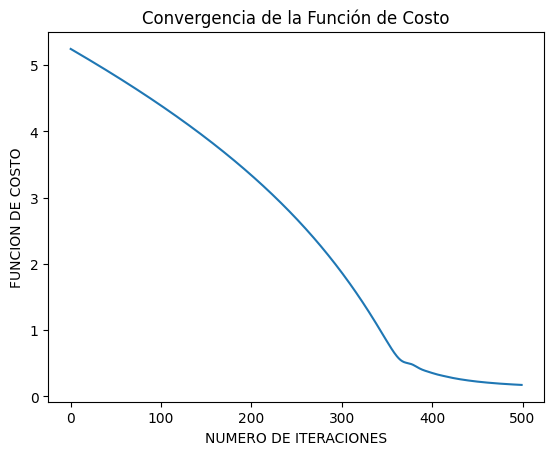

In [ ]:
plt.plot(loss_i)
plt.title('Convergencia de la Función de Costo')
plt.ylabel('FUNCION DE COSTO')
plt.xlabel('NUMERO DE ITERACIONES')
plt.savefig('convergencia_funcion_de_costo.svg', format='svg')
print(f'LOSS: {loss}')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [ ]:
d_pred_l2 = forwarde(VES.synres)

In [ ]:
!pip install pygimli

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
from pygimli.physics.ves import VESRhoModelling, VESManager
from pygimli.viewer.mpl import drawModel1D

In [ ]:
synres = [35, 150, 350, 90, 20]
synthk = [4, 8, 15, 23]
ab2 = np.logspace(0.4, 2.2, 30)

ves = VESManager()
rhoa, error = ves.simulate(synthk+synres, ab2=ab2, mn2=ab2/3,
                           noiseLevel=0.03, seed=1337)

In [ ]:
thk = np.logspace(0.0, 0.9, 15)
f = VESRhoModelling(thk=thk, ab2=ab2, mn2=ab2/3)

INFO:pyGIMLi:Found 1 regions.
09/08/25 - 19:50:26 - pyGIMLi - INFO - Found 1 regions.


In [ ]:
inve = pg.Inversion(fop=f, verbose=False)

In [ ]:
inve.transData = pg.trans.TransLog()  # log transformation also for data
inve.transModel = pg.trans.TransLogLU(1, 1000)  # lower and upper bound

In [ ]:
print("inversion with lam=100")
res100 = inve.run(rhoa, error, lam=100)
print('rrms={:.2f}%, chi^2={:.3f}'.format(inve.relrms(), inve.chi2()))

print("inversion with lam=10")
res10 = inve.run(rhoa, error, lam=10)
print('rrms={:.2f}%, chi^2={:.3f}'.format(inve.relrms(), inve.chi2()))

print("inversion with second order smoothness")
inve.setRegularization(cType=2)
resC2 = inve.run(rhoa, error, lam=20)
print('rrms={:.2f}%, chi^2={:.3f}'.format(inve.relrms(), inve.chi2()))

inversion with lam=100
rrms=4.23%, chi^2=1.991
inversion with lam=10
rrms=3.27%, chi^2=1.191
inversion with second order smoothness
rrms=3.33%, chi^2=1.233


In [ ]:
@tf.function
def forwardipi(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant([4.186, 37.49], dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
resipi =  tf.constant([34.58, 218.4, 26.54], dtype = tf.float64)

d_pred_ipi = forwardipi(resipi)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

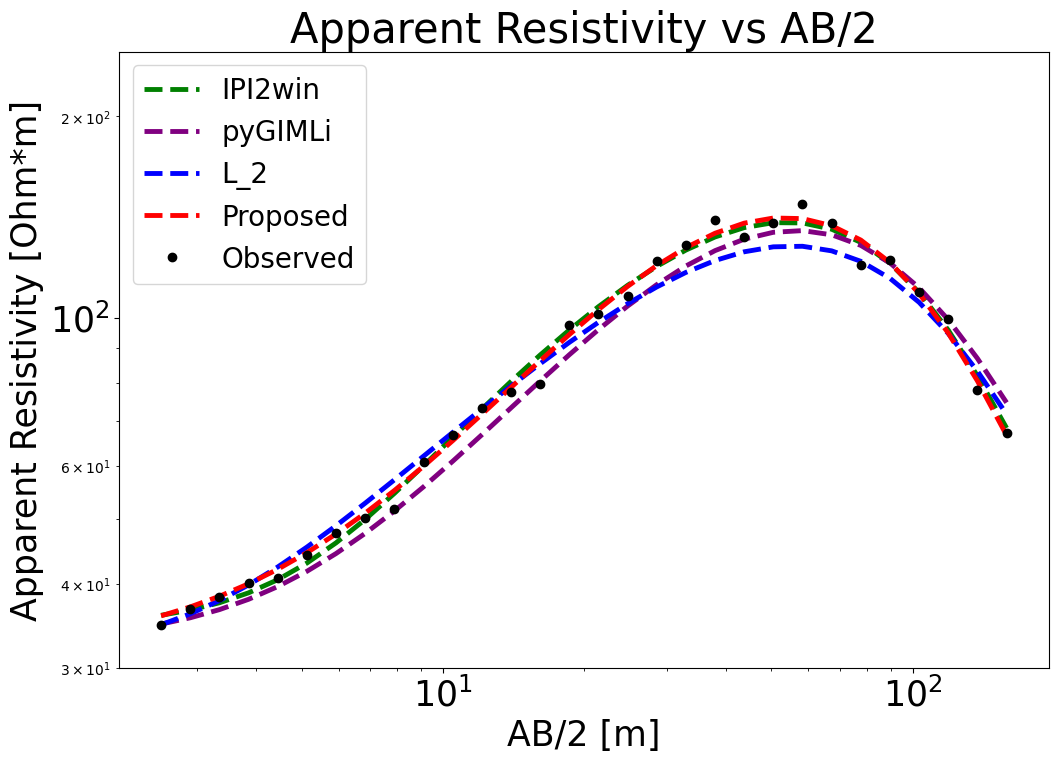

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico principal
fig, ax_main = plt.subplots(figsize=(12, 8))


# Curva ajustada ipi2win
ax_main.plot(ab2, d_pred_ipi, linestyle='dashed', label='IPI2win', color='green', linewidth=3.5)

# Curva ajustada pigymli
ax_main.plot(ab2, inve.response, linestyle='dashed', label='pyGIMLi', color='purple', linewidth=3.5)

# Curva ajustada solo l_2 norm
ax_main.plot(ab2, d_pred_l2, linestyle='dashed', label='L_2', color='blue', linewidth=3.5)

# Curva ajustada con método propuesto
ax_main.plot(ab2, d_pred, linestyle='dashed', label='Proposed', color='red', linewidth=3.5)



# Datos observados
ax_main.plot(ab2, synthetic_data, 'o', label='Observed', color='black', markersize=6)

# Configuración de ejes y títulos
ax_main.set_ylim(30, 250)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=25)
ax_main.set_ylabel('Apparent Resistivity [Ohm*m]', fontsize=25)
ax_main.set_title('Apparent Resistivity vs AB/2', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=25)
ax_main.legend(fontsize=20, loc='upper left')

# Desactivar la cuadrícula
ax_main.grid(False)

# Establecer el fondo del gráfico
fig.patch.set_facecolor('white')

# Guardar como SVG
file_name = 'responseEXP1.svg'
plt.savefig(file_name, format='svg', bbox_inches='tight')

# Descargar el archivo en Colab
#files.download(file_name)

# Mostrar el gráfico
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

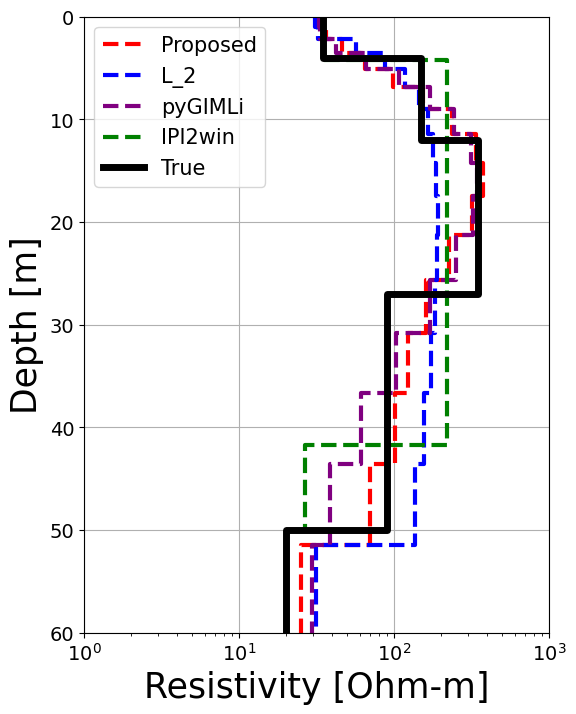

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico
fig, ax = plt.subplots(figsize=(6, 8))

# Modelo invertido método propuesto
drawModel1D(ax, thickness=np.logspace(0.0, 0.9, 15), values=scaled_model_pred, plot='semilogx',
            color='red', linestyle='dashed', label='Proposed', linewidth=3.0)

# Modelo invertido solo norma l_2
drawModel1D(ax, thickness=np.logspace(0.0, 0.9, 15), values=VES.synres.numpy(), plot='semilogx',
            color='blue', linestyle='dashed', label='L_2', linewidth=3.0)

# Modelo invertido pygimli
drawModel1D(ax, thickness=thk, values=resC2, plot='semilogx', color='purple', linestyle='dashed', label='pyGIMLi', linewidth=3.0)

# Modelo invertido ipi2win
drawModel1D(ax, thickness=[4.186, 37.49], values=resipi, plot='semilogx', color='green', linestyle='dashed', label='IPI2win', linewidth=3.0)


# Modelo Teórico
drawModel1D(ax, thickness=synthk, values=synres, plot='semilogx', linewidth=5.0, color='black', label='True')

# Configuración de los ejes
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=25)
ax.set_ylabel('Depth [m]', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=15, loc='upper left')
plt.xlim([1, 10**3])

# Establecer el fondo del gráfico
fig.patch.set_facecolor('white')

# Guardar como SVG
file_name = 'EXP1.svg'
plt.savefig(file_name, format='svg', bbox_inches='tight')

# Descargar el archivo
#files.download(file_name)

# Mostrar el gráfico
plt.show()

In [ ]:
import numpy as np

def rmspe(y_true, y_pred):
    """
    Calcula el Root Mean Squared Percentage Error (RMSPE) en porcentaje.

    Parámetros:
    y_true : array-like
        Valores observados o reales.
    y_pred : array-like
        Valores predichos.

    Retorna:
    float : RMSPE en porcentaje
    """
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)

    mse = np.mean((y_true - y_pred) ** 2)
    rmspe = np.sqrt(mse) / np.mean(np.abs(y_true)) * 100
    return rmspe

RMSPE_propuesto = rmspe(synthetic_data, d_pred)
RMSPE_l2 = rmspe(synthetic_data, d_pred_l2)
RMSPE_pygimli = rmspe(synthetic_data, inve.response)
RMSPE_ipi2win = rmspe(synthetic_data, d_pred_ipi)
print(f"RMSPE (%) (propuesto): {RMSPE_propuesto:.4f}")
print(f"RMSPE (%) (l_2): {RMSPE_l2:.4f}")
print(f"RMSPE (%) (pygimli): {RMSPE_pygimli:.4f}")
print(f"RMSPE (%) (ipi2win): {RMSPE_ipi2win:.4f}")

RMSPE (%) (propuesto): 4.1104
RMSPE (%) (l_2): 8.3630
RMSPE (%) (pygimli): 6.9260
RMSPE (%) (ipi2win): 4.3877


In [ ]:
import numpy as np

def sample_resistivities_at_depths(resistivities, thicknesses, depths):
    """
    Asigna la resistividad de cada capa a un conjunto de profundidades dadas.
    """
    resistivities = np.array(resistivities, dtype=float)
    thicknesses   = np.array(thicknesses, dtype=float)

    # Limites superiores de cada capa
    layer_tops = np.concatenate(([0], np.cumsum(thicknesses)))

    rho_out = np.empty_like(depths, dtype=float)
    for i, z in enumerate(depths):
        layer_idx = np.searchsorted(layer_tops, z, side='right') - 1
        if layer_idx < len(resistivities):
            rho_out[i] = resistivities[layer_idx]
        else:
            # Handle cases where depth is beyond the defined layers
            if len(resistivities) > 0:
                rho_out[i] = resistivities[-1] # Assign the last layer's resistivity
            else:
                rho_out[i] = np.nan # Or np.nan if no layers are defined
    return rho_out

# Profundidad total máxima
total_depth_synth = np.sum(synthk)

# --- 1) Generar points points aleatorios únicos para todos ---
np.random.seed(42)  # reproducible
n_points = 200
depths_rand = np.sort(np.random.uniform(0, total_depth_synth, n_points))

# --- 2) Evaluar cada modelo en las mismas profundidades ---
rhos_pred_l2 = sample_resistivities_at_depths(d_pred_l2, thk, depths_rand)
rhos_pred    = sample_resistivities_at_depths(d_pred,    thk, depths_rand)
rhos_pygimli = sample_resistivities_at_depths(inve.response, thk, depths_rand)
rhos_real    = sample_resistivities_at_depths(synres, synthk, depths_rand)
rhos_ipi2win = sample_resistivities_at_depths(d_pred_ipi, [4.186, 37.49], depths_rand)


In [ ]:
RMSPE_propuesto_model = rmspe(np.log10(rhos_real), np.log10(rhos_pred_l2))
RMSPE_l2_model        = rmspe(np.log10(rhos_real), np.log10(rhos_pred))
RMSPE_pygimli_model    = rmspe(np.log10(rhos_real), np.log10(rhos_pygimli))
RMSPE_ipi2win_model    = rmspe(np.log10(rhos_real), np.log10(rhos_ipi2win))
print(f"RMSPE (%) (propuesto): {RMSPE_propuesto_model:.4f}")
print(f"RMSPE (%) (l_2): {RMSPE_l2_model:.4f}")
print(f"RMSPE (%) (pygimli): {RMSPE_pygimli_model:.4f}")
print(f"RMSPE (%) (ipi2win): {RMSPE_ipi2win_model:.4f}")

RMSPE (%) (propuesto): 22.0768
RMSPE (%) (l_2): 22.4735
RMSPE (%) (pygimli): 23.4688
RMSPE (%) (ipi2win): 30.4778
